In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Imports
!pip install tensorflow

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.ppo_training import train, prepare_datasets, testing_simulation
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
# @title Load and check data

# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps

raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")

From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [ ]:
# @title Add indicators

# Базовые массивы (создаём один раз)
close  = df['Close'].to_numpy(np.float64)
high   = df['High'].to_numpy(np.float64)
low    = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

# Словарь для новых колонок
new_cols = {}
obv_arr = obv_numba(close, volume)

for i in range(35, 246, 7):
    ema_i = ema_numba(close, i)
    sma_i = sma_numba(close, i)
    adx_i = adx_numba(high, low, close, i)
    atr_i = atr_numba(high, low, close, i)
    rsi_i = rsi_numba(close, i)

    fast = i
    slow = i * 2
    sig  = i // 2  # вместо int(i/2)

    macd, macd_signal, macd_hist = macd_numba(close, fast, slow, sig)
    stoch_k, stoch_d = stoch_numba(high, low, close, i, i // 2)
    boll_mid, boll_up, boll_dn = bollinger_numba(close, i, 2.0)
    cci_i  = cci_numba(high, low, close, i)
    willr_i= williams_r_numba(high, low, close, i)
    mfi_i  = mfi_numba(high, low, close, volume, i)
    roc_i  = roc_numba(close, i)
    vwap_i = vwap_numba(high, low, close, volume, i)  # если это rolling VWAP на окне i

    new_cols.update({
        f"EMA_{i}":          ema_i,
        f"SMA_{i}":          sma_i,
        f"ADX_{i}":          adx_i,
        f"ATR_{i}":          atr_i,
        f"RSI_{i}":          rsi_i,
        f"MACD_{i}":         macd,
        f"MACD_signal_{i}":  macd_signal,
        f"MACD_hist_{i}":    macd_hist,
        f"STOCH_K_{i}":      stoch_k,
        f"STOCH_D_{i}":      stoch_d,
        f"BOLL_MID_{i}":     boll_mid,
        f"BOLL_UP_{i}":      boll_up,
        f"BOLL_DN_{i}":      boll_dn,
        f"OBV":              obv_arr,
        f"CCI_{i}":          cci_i,
        f"WILLR_{i}":        willr_i,
        f"MFI_{i}":          mfi_i,
        f"ROC_{i}":          roc_i,
        f"VWAP_{i}":         vwap_i,
    })

# Добавляем все столбцы разом — без фрагментации
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(df.columns.to_list())

['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_35', 'SMA_35', 'ADX_35', 'ATR_35', 'RSI_35', 'MACD_35', 'MACD_signal_35', 'MACD_hist_35', 'STOCH_K_35', 'STOCH_D_35', 'BOLL_MID_35', 'BOLL_UP_35', 'BOLL_DN_35', 'OBV', 'CCI_35', 'WILLR_35', 'MFI_35', 'ROC_35', 'VWAP_35', 'EMA_42', 'SMA_42', 'ADX_42', 'ATR_42', 'RSI_42', 'MACD_42', 'MACD_signal_42', 'MACD_hist_42', 'STOCH_K_42', 'STOCH_D_42', 'BOLL_MID_42', 'BOLL_UP_42', 'BOLL_DN_42', 'CCI_42', 'WILLR_42', 'MFI_42', 'ROC_42', 'VWAP_42', 'EMA_49', 'SMA_49', 'ADX_49', 'ATR_49', 'RSI_49', 'MACD_49', 'MACD_signal_49', 'MACD_hist_49', 'STOCH_K_49', 'STOCH_D_49', 'BOLL_MID_49', 'BOLL_UP_49', 'BOLL_DN_49', 'CCI_49', 'WILLR_49', 'MFI_49', 'ROC_49', 'VWAP_49', 'EMA_56', 'SMA_56', 'ADX_56', 'ATR_56', 'RSI_56', 'MACD_56', 'MACD_signal_56', 'MACD_hist_56', 'STOCH_K_56', 'STOCH_D_56', 'BOLL_MID_56', 'BOLL_UP_56', 'BOLL_DN_56', 'CCI_56', 'WILLR_56', 'MFI_56', 'ROC_56', 'VWAP_56', 'EMA_63', 'SMA_63', 'ADX_63', 'ATR_63', 'RSI_63', 'MACD_63', 

In [ ]:
# @title Объяснение параметров и метрик
"""
PPO_UPDATES — количество крупных циклов обучения (policy updates). Каждый цикл включает:
- Сбор PPO_ROLLOUT шагов из PPO_N_ENV параллельных окружений.
- Разбиение собранных данных на мини-батчи PPO_BATCH_SIZE.
- PPO_EPOCHS проходов оптимизации по этим батчам.
Таким образом, общее число шагов взаимодействия со средой за весь запуск равно PPO_UPDATES × PPO_N_ENV × PPO_ROLLOUT.
На что влияет:
- Общее время и объём обучения. Большее значение → больше данных и gradient-обновлений → дольше тренировка, выше шанс достичь лучшей политики.
- Риск переобучения.При фиксированных данных каждая лишняя итерация может привести к “запоминанию” конкретных траекторий и ухудшению обобщающей способности.
- Использование вычислительных ресурсов. PPO_UPDATES напрямую задаёт количество итераций оптимизации, что определяет нагрузку на GPU/CPU.
Как подбирать:
- Базовая точка: 50 циклов — типичное стартовое значение для средних по сложности задач (≈1 млн шагов при 40 × 512 × 50).
- Если агент недоучивается (наградная кривая всё ещё растёт) — увеличьте параметр (например, до 100–200), чтобы дать модели больше времени на освоение среды.
- Если награда стабилизируется или падает до завершения обучения — уменьшайте PPO_UPDATES или используйте раннюю остановку по метрике валидации.
- Ориентир по шагам среды: выберите целевой объём взаимодействий (например, 2 млн шагов) и рассчитайте PPO_UPDATES = целевые_шаги / (PPO_N_ENV × PPO_ROLLOUT).
- Грамотная настройка PPO_UPDATES помогает балансировать между временем обучения, объёмом данных и качеством итоговой политики.


PPO_N_ENV - задаёт число окружений (environment instances), запускаемых одновременно. Каждый из них параллельно генерирует свои траектории взаимодействия с миром.
Зачем нужны несколько сред:
- Быстрая генерация данных. Одновременно работающие окружения собирают шаги опыта параллельно, что ускоряет обучение: за один и тот же реальный промежуток времени вы получаете PPO_N_ENV раз больше данных.
- Снижение корреляции. Последовательные шаги в одной среде сильно коррелированы. Запуск множества независимых эпизодов уменьшает зависимость между образцами, что делает оценку градиента более надёжной.
- Стабильное обучение. При большем разнообразии исходных состояний и траекторий политика быстрее покрывает пространство состояний, что помогает избежать локальных минимумов.
Как подбирать:
- Ограничения железа. Увеличение PPO_N_ENV потребляет больше CPU/GPU и памяти. Выбирайте значение, которое эффективно загружает доступные ресурсы (типично 8–64).
- Размер батча. Общее число шагов на одно обновление равно PPO_N_ENV × PPO_ROLLOUT. Если вам нужен крупный батч (например, для стабильности), проще увеличить PPO_N_ENV, чем сильно удлинять PPO_ROLLOUT.
- Время взаимодействия. Если среда медленная или взаимодействие дорогое, увеличивайте PPO_N_ENV, чтобы по максимуму распараллелить сбор данных.
- Когда уменьшать. Если компьютер не справляется (CPU загружен на 100%, задержки растут), снизьте число сред или используйте асинхронную схему (A3C, RLLib).
Правильное значение PPO_N_ENV — компромисс между скоростью обучения и доступными ресурсами; начинайте с числа, оптимально загружающего ваш сервер, и корректируйте в зависимости от стабильности и производительности обучения.


PPO_ROLLOUT - задаёт длину собранной траектории из каждого окружения перед одним обновлением политики.
Если PPO_N_ENV = 40 и PPO_ROLLOUT = 512, то за цикл обучения собирается 40 × 512 = 20 480 шагов взаимодействия.
На что влияет:
- Размер батча и скорость обновления. Длинный rollout увеличивает объём данных на обновление и реже вызывает оптимизацию, что делает каждое обновление более «массовым», но редким.
- Корреляция данных. Чем длиннее траектория, тем более последовательные (коррелированные) шаги попадают в выборку. Это может замедлить обучение,
особенно в задачах с высокой автокорреляцией.
- Обновление значений и преимущества. Rollout определяет глубину вычисления возвратов/GAE. Слишком короткий сегмент даёт «обрезанные» оценки,
а слишком длинный может приводить к устареванию данных, если политика за время сбора уже изменилась.
- Потребление памяти. Хранение длинных траекторий требует больше RAM/VRAM, что может ограничить максимальное значение на слабом оборудовании.
Как подбирать:
- Стартовое значение: 128–512 шагов — типичный диапазон для большинства задач в игре или управлении роботами.
- Баланс с PPO_N_ENV: поддерживайте общий размер батча (PPO_N_ENV × PPO_ROLLOUT) в разумных пределах (например, 8 000–30 000 шагов). Если увеличиваете число сред, rollout можно уменьшить.
- Если обучение шумное и нестабильное: попробуйте удлинить rollout, чтобы каждое обновление опиралось на большее количество данных.
- Если среда очень медленная: укорачивайте rollout и/или увеличивайте PPO_N_ENV, чтобы чаще обновлять политику и быстрее получать обратную связь.
- Анализ качества: отслеживайте кривые награды и скорость сходимости; оптимальное значение rollout — то, при котором прирост награды стабилен, а время до обновления не слишком велико.
Итог: PPO_ROLLOUT задаёт, сколько последовательных шагов собирает каждая среда до обновления. Он напрямую влияет на размер батча, корреляцию данных и частоту обновлений, поэтому выбирать его нужно в связке с количеством параллельных окружений и возможностями оборудования.


PPO_CLIP_RATIO — центральный гиперпараметр в алгоритме Proximal Policy Optimization. Его называют «шириной зажима» и обычно обозначают ε.
В PPO вычисляется отношение вероятностей действий новой политики и старой. Чтобы не позволять обновлённой политике слишком далеко «отклоняться» от старой, каждая величина
r(θ) проходит через функцию clip(r, 1-ε, 1+ε) и затем берётся минимум.
На что влияет:
- Стабильность обучения. Чем меньше PPO_CLIP_RATIO, тем более «осторожные» обновления: политика меняется медленно, но обучение устойчивее.
- Скорость и амплитуда обновлений.Больший параметр позволяет быстрее приспосабливаться к изменениям среды — но есть риск «разлета» градиентов и деградации.
- Баланс исследования/эксплуатации. При небольшом ε алгоритм дольше сохраняет свойства старой политики, что снижает риск забывания, но может замедлить улучшение.
Как подбирать:
- Стартовое значение: 0.1–0.3 (типичный базовый диапазон из статьи PPO).
- Если обучение нестабильно или награда сильно колеблется, уменьшите ε (например, 0.1 или 0.05).
- Если модель «залипает» и улучшается медленно, попробуйте увеличить (0.3 и выше), но контролируйте, чтобы потери и дивергенция не расходились.
- Иногда применяют адаптивную схему: отслеживают фактический KL-дивергенцию между старой и новой политиками и динамически корректируют PPO_CLIP_RATIO, но это усложняет реализацию.
Итого: PPO_CLIP_RATIO — это безопасный «коридор», внутри которого политика может двигаться за один шаг обновления. Правильная настройка этого параметра критична для того, чтобы обучение было и стабильным, и достаточно быстрым.


PPO_MAX_GRAD_NORM - задаёт верхнее ограничение на норму (длину) вектора градиента при обновлении параметров сети.
После вычисления градиентов они при необходимости «обрезаются» так, чтобы их норма не превышала это значение.
На что влияет:
- Стабильность обучения. Ограничение градиентов предотвращает резкие скачки параметров и защищает от взрывных градиентов, особенно при высокой скорости обучения.
- Сходимость. При корректном «клиппинге» градиента модель движется к минимуму более плавно, что способствует более надёжной сходимости.
- Скорость обучения. Слишком низкий порог может замедлить адаптацию, поскольку сильные градиенты будут «срезаться», а слишком высокий — не окажет должной стабилизации.
Как подбирать:
- Стартовое значение: 0.5–1.0 — типичный диапазон для большинства задач с PPO.
- Если наблюдаются взрывы градиента (loss резко скачет, параметры становятся nan), уменьшите значение.
- Если обучение идёт слишком медленно и градиенты редко достигают порога, можно слегка увеличить PPO_MAX_GRAD_NORM.
- Комбинируйте с learning rate: при повышении PPO_ACTOR_LR или PPO_CRITIC_LR может потребоваться более жёсткое ограничение градиента.
Итого: PPO_MAX_GRAD_NORM — «страховочный трос» для градиентов, удерживающий шаги оптимизации в разумных пределах.
Его грамотная настройка помогает избежать нестабильности и сохранить баланс между скоростью и надёжностью обучения.


PPO_TARGET_KL — целевое значение KL-дивергенции между старой и новой политиками. После каждого обновления алгоритм измеряет фактическую KL-дивергенцию и сравнивает её с целевым порогом.
На что влияет:
- Контроль шага обновления. Если реальная дивергенция превышает PPO_TARGET_KL, дальнейшие итерации оптимизации останавливаются или замедляются — это предотвращает слишком резкие изменения политики.
- Стабильность обучения. Поддержание дивергенции вблизи целевого значения способствует более плавной и предсказуемой траектории обучения.
- Компромисс между скоростью и надёжностью. Более низкий порог делает обучение осторожным, но может замедлить прогресс; более высокий — ускоряет адаптацию, но повышает риск нестабильности.
Как подбирать:
- Стартовое значение: 0.01 — распространённый базовый выбор.
- Если наблюдается «разлёт» политики (потери нестабильны, награда скачет), попробуйте уменьшить PPO_TARGET_KL, чтобы жёстче контролировать изменения.
- Если обучение идёт слишком медленно и KL практически не достигает порога, значение можно поднять (например, до 0.02–0.05), позволяя большей свободе обновлений.
- Адаптивные схемы: иногда вводят постепенное снижение порога по ходу обучения, чтобы сначала быстро исследовать, а потом стабилизироваться.
Итого: PPO_TARGET_KL служит «стоп-сигналом» для слишком больших отклонений новой политики от старой.
Правильно подобранный порог помогает сочетать быстрое обучение с контролируемой стабильностью, что особенно важно при длительных или чувствительных к разрывам задачах.


PPO_GAMMA (discount factor) — коэффициент дисконтирования будущих вознаграждений.
Значение ближе к 1 делает агент более «дальнозорким», учитывая долгосрочные последствия действий.
Более низкое значение заставляет агента концентрироваться на ближайшем вознаграждении.
Типичные значения: 0.99, 0.95 — выбираются в зависимости от глубины временного горизонта задачи.


PPO_LAM (lambda) — параметр обобщённой оценки преимущества (GAE), регулирующий баланс между bias и variance.
Значение 1.0 приводит к меньшему смещению, но более высокому разбросу.
Значение 0.0 повышает смещение, но уменьшает разброс, что делает обучение более «шумным».
Часто используется 0.95–0.97, но оптимальное значение зависит от особенностей среды и политики.
Практика подбора:
- Начать с общепринятых значений (gamma=0.99, lam=0.95).
- Выполнить поиск по сетке (grid search) или использованию систематических экспериментов, меняя по одному параметру.
- Анализировать метрики обучения (скорость сходимости, стабильность, итоговое качество политики) и при необходимости корректировать параметры.


МЕТРИКИ:

policy_loss = -0.01140
Отражает, насколько сильно обновление политики снижает целевую функцию. Небольшое отрицательное значение говорит о том,
что текущие обновления улучшают политику, но шаги достаточно осторожные. Если абсолютное значение постоянно растёт (становится более отрицательным),
модель активно адаптируется; если стремится к нулю — политика стабилизируется.

value_loss = 0.72330
Показывает ошибку критика при оценке ожидаемого вознаграждения. Чем меньше, тем точнее предсказания.
Значение выше ~0.7 может означать, что критик ещё не до конца обучен или задача сложная.
Если loss со временем снижается — критик становится точнее; рост может указывать на переобучение политики или слишком высокую скорость обучения критика.

entropy = 0.43223
Измеряет “случайность” действий (степень исследования). 0.43 — умеренная энтропия: политика сохраняет разнообразие, но уже не совершенно случайна.
По мере обучения энтропия обычно убывает: слишком быстрое падение — риск преждевременной детерминированности, слишком медленное — модель долго остаётся хаотичной.

approx_kl = 0.05351
Приблизительная KL-дивергенция между старой и новой политиками. Она показывает, насколько сильно изменяется политика после обновления.
Значение 0.0535 в пять раз превышает ваш целевой PPO_TARGET_KL = 0.01, что может сигнализировать о слишком резких шагах.
Если approx_kl стабильно выше порога, стоит уменьшить PPO_CLIP_RATIO или скорость обучения.

teacher_kl = 0.0457
Среднее значение KL-дивергенции между текущей политикой и teacher‑моделью. В коде собранные на каждой итерации t_kl складываются в список teacher_kls, а затем усредняются.
Значение ~0.046 говорит, что политика умеренно отклоняется от teacher: выше нуля (политика учится отличаться), но далеко от заданного лимита 0.1.

clip_fraction = 0.0124
Доля шагов, где отношение вероятностей действий вышло за пределы 1 ± PPO_CLIP_RATIO и была применена обрезка.
В коде эти события накапливаются в clipfracs, после чего берётся их среднее. Низкое значение (~1.2 %) означает,
что обновления оставались в пределах допустимого коридора, и политика изменялась достаточно плавно.

avg_return = -0.1172
Среднее возвращённое вознаграждение по собранной траектории за обновление.
В коде вычисляется как среднее значение traj.returns и записывается в метрики.
Отрицательная величина показывает, что агент в среднем пока приносит убыток — требуется дальнейшее обучение или настройка гиперпараметров.

Что означают изменения во времени
Падение policy_loss и value_loss — признак прогресса, но отслеживайте, чтобы value_loss не рос после изначального падения.
Снижение энтропии — нормальный процесс, но важно, чтобы она не опускалась слишком рано; в противном случае увеличьте PPO_C2.
Пики approx_kl выше целевого порога — сигнал, что обновления могут быть слишком агрессивными;
при регулярном превышении значения следует уменьшить PPO_ACTOR_LR, PPO_CLIP_RATIO или число эпох PPO_EPOCHS.

"""

train: debug mode enabled
CPU available: 44
Teacher policy


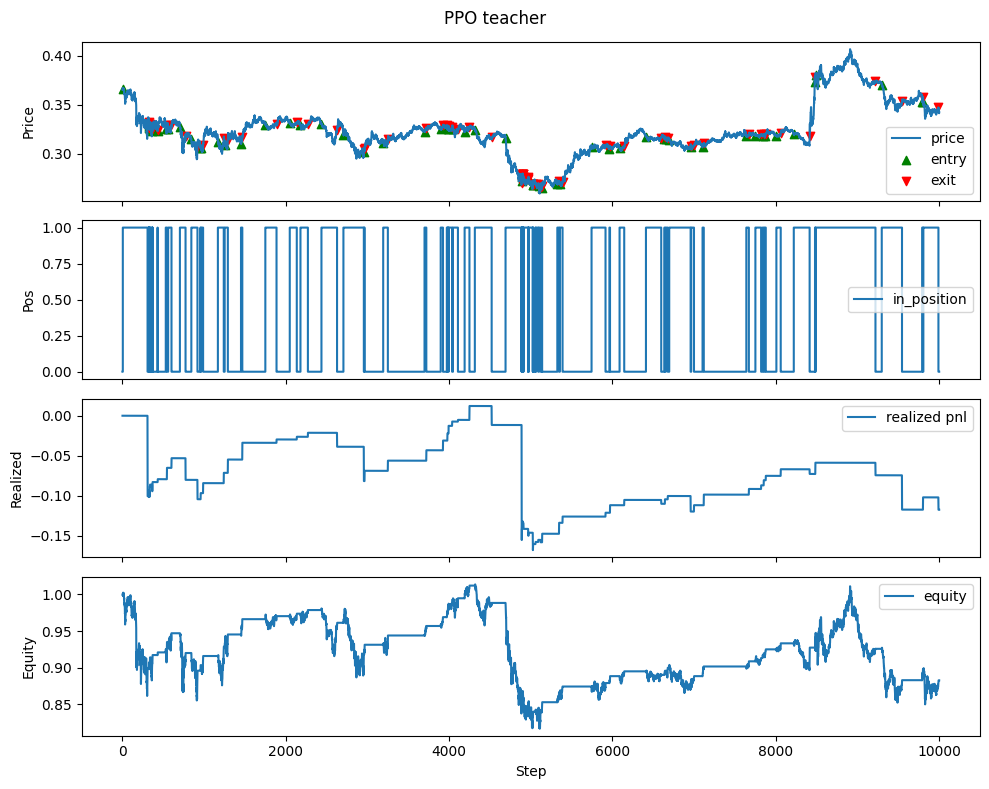


Evaluate profit:
Realized PnL: -0.1174
Annual Return: -6.1722
Sharpe Ratio: -3.8209
Sortino Ratio: -3.4677
Closed trades: 77
Avg PnL per trade: -0.0014
Maximum Drawdown: 0.1945
Calmar Ratio: -31.7399
Profit Factor: 0.8017
Win Rate: 67.5325
Average Win/Loss Ratio: 0.3854
Recovery Factor: -0.6038
Time Under Water: 0.9921
Value at Risk: 0.0033

collect_trajectories: n_env=20 rollout=512 seq_len=5
Valid Indexes length :578071

Updating PPO:
Epoch 1/10: batch: policy_loss=-0.01777 value_loss=1.15632 entropy=0.45245 approx_kl=0.02401
Epoch 2/10: batch: policy_loss=0.01366 value_loss=1.00962 entropy=0.51168 approx_kl=0.02896
Epoch 3/10: batch: policy_loss=0.02207 value_loss=0.88658 entropy=0.49171 approx_kl=0.01721
Epoch 3/10: batch: policy_loss=0.05945 value_loss=0.82273 entropy=0.47642 approx_kl=0.06809
Epoch 4/10: batch: policy_loss=-0.00538 value_loss=0.51575 entropy=0.46686 approx_kl=0.01699
Epoch 4/10: batch: policy_loss=0.02235 value_loss=0.68569 entropy=0.47646 approx_kl=0.10731
Epoc

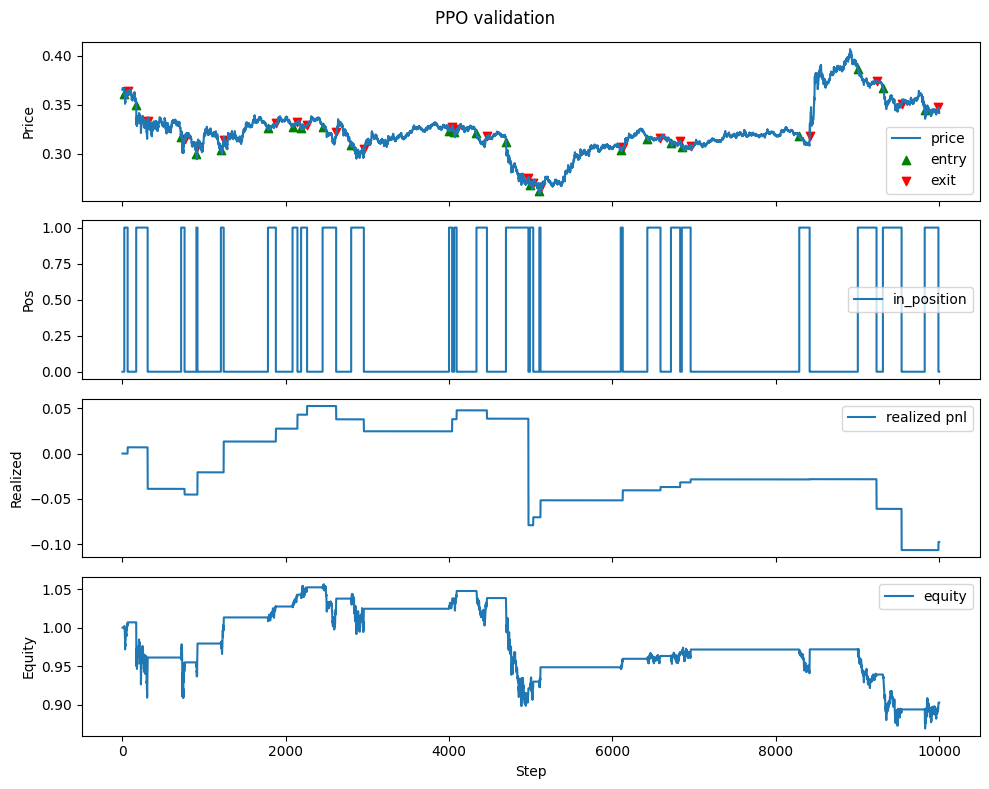


Evaluate_profit:
Realized PnL: -0.0973
Annual Return: -5.1146
Sharpe Ratio: -3.9457
Sortino Ratio: -2.5064
Closed trades: 24
Avg PnL per trade: -0.0039
Maximum Drawdown: 0.1772
Calmar Ratio: -28.8702
Profit Factor: 0.6672
Win Rate: 66.6667
Average Win/Loss Ratio: 0.3336
Recovery Factor: -0.5492
Time Under Water: 0.9229
Value at Risk: 0.0021

collect_trajectories: n_env=20 rollout=512 seq_len=5
Valid Indexes length :578071

Updating PPO:
Epoch 1/10: batch: policy_loss=0.07354 value_loss=0.34566 entropy=0.31171 approx_kl=0.00222
Epoch 1/10: batch: policy_loss=0.01326 value_loss=0.36495 entropy=0.29626 approx_kl=0.02586
Epoch 2/10: batch: policy_loss=0.02760 value_loss=0.35525 entropy=0.30429 approx_kl=-0.00648
Epoch 2/10: batch: policy_loss=0.00380 value_loss=0.43522 entropy=0.28913 approx_kl=0.02313
Epoch 3/10: batch: policy_loss=0.01153 value_loss=0.28732 entropy=0.26887 approx_kl=0.04046
Epoch 4/10: batch: policy_loss=-0.00585 value_loss=0.32090 entropy=0.27277 approx_kl=0.01971
Epoc

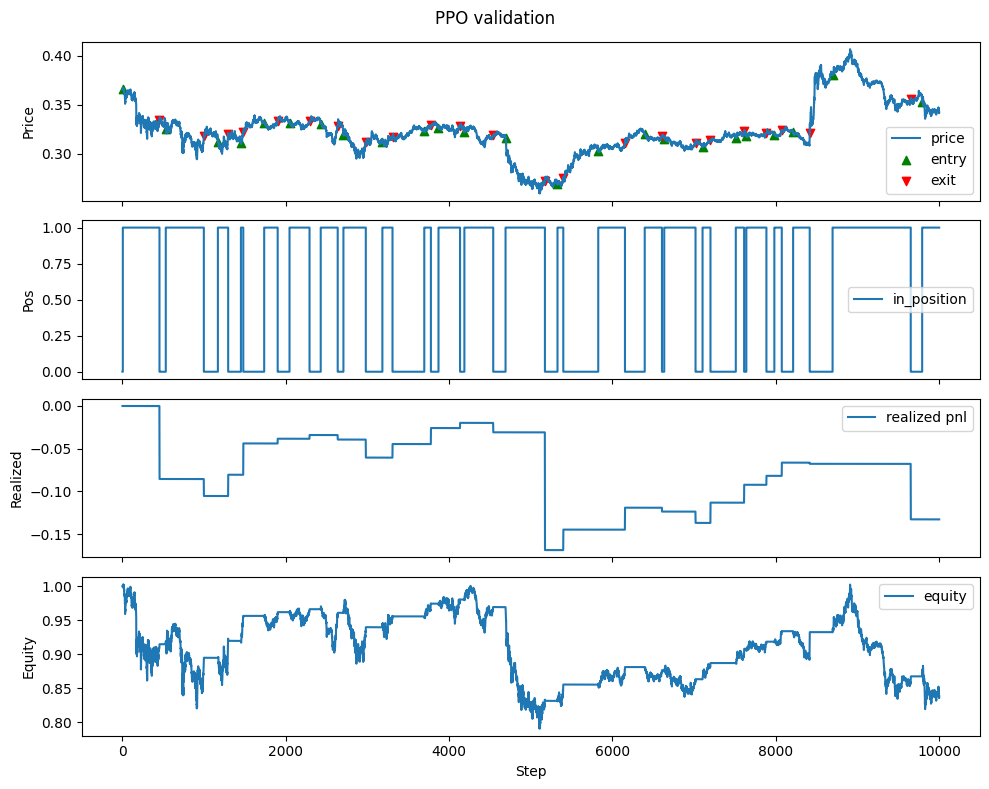


Evaluate_profit:
Realized PnL: -0.1327
Annual Return: -8.5
Sharpe Ratio: -5.0563
Sortino Ratio: -5.3586
Closed trades: 23
Avg PnL per trade: -0.0056
Maximum Drawdown: 0.2112
Calmar Ratio: -40.2453
Profit Factor: 0.6432
Win Rate: 56.5217
Average Win/Loss Ratio: 0.4947
Recovery Factor: -0.7656
Time Under Water: 0.9994
Value at Risk: 0.0035

collect_trajectories: n_env=20 rollout=512 seq_len=5
Valid Indexes length :578071

Updating PPO:
Epoch 1/10: batch: policy_loss=-0.01574 value_loss=0.20901 entropy=0.24582 approx_kl=0.00410
Epoch 1/10: batch: policy_loss=-0.00810 value_loss=0.17748 entropy=0.25683 approx_kl=0.01463
Epoch 1/10: batch: policy_loss=0.01045 value_loss=0.19348 entropy=0.20040 approx_kl=0.00471
Epoch 1/10: batch: policy_loss=0.00325 value_loss=0.20213 entropy=0.22510 approx_kl=0.03335
Epoch 2/10: batch: policy_loss=-0.00040 value_loss=0.16414 entropy=0.24151 approx_kl=0.02048
Epoch 3/10: batch: policy_loss=-0.01037 value_loss=0.17639 entropy=0.20811 approx_kl=0.02633
Epoch

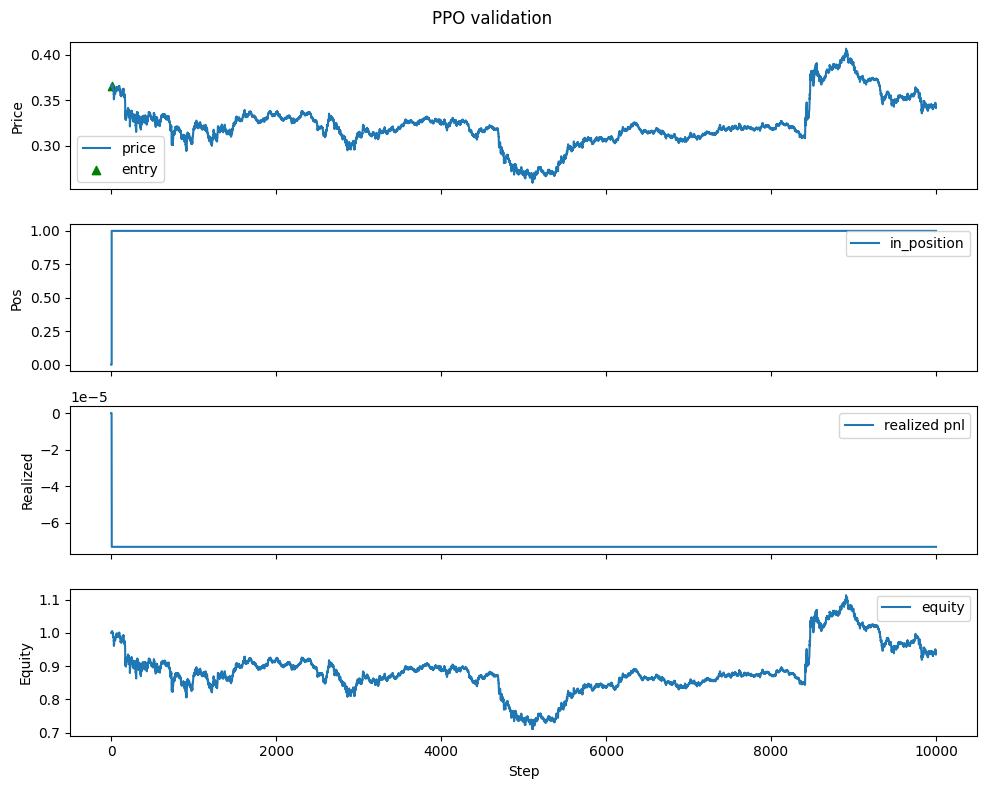


Evaluate_profit:
Realized PnL: -0.0001
Annual Return: -3.3124
Sharpe Ratio: -1.7231
Sortino Ratio: -2.3369
Closed trades: 0
Avg PnL per trade: 0.0
Maximum Drawdown: 0.2923
Calmar Ratio: -11.3338
Profit Factor: 0.0
Win Rate: 0.0
Average Win/Loss Ratio: 0.0
Recovery Factor: -0.2156
Time Under Water: 0.9964
Value at Risk: 0.0038

collect_trajectories: n_env=20 rollout=512 seq_len=5
Valid Indexes length :578071

Updating PPO:
Epoch 1/10: batch: policy_loss=0.00746 value_loss=0.09033 entropy=0.22117 approx_kl=0.00596
Epoch 1/10: batch: policy_loss=-0.00323 value_loss=0.14826 entropy=0.22543 approx_kl=0.02042
Epoch 2/10: batch: policy_loss=0.01716 value_loss=0.09083 entropy=0.20143 approx_kl=-0.01060
Epoch 2/10: batch: policy_loss=-0.01361 value_loss=0.08641 entropy=0.20239 approx_kl=0.03731
Epoch 3/10: batch: policy_loss=-0.00508 value_loss=0.10529 entropy=0.24290 approx_kl=0.02727
Epoch 4/10: batch: policy_loss=0.01312 value_loss=0.07572 entropy=0.22974 approx_kl=0.01620
Epoch 4/10: batch

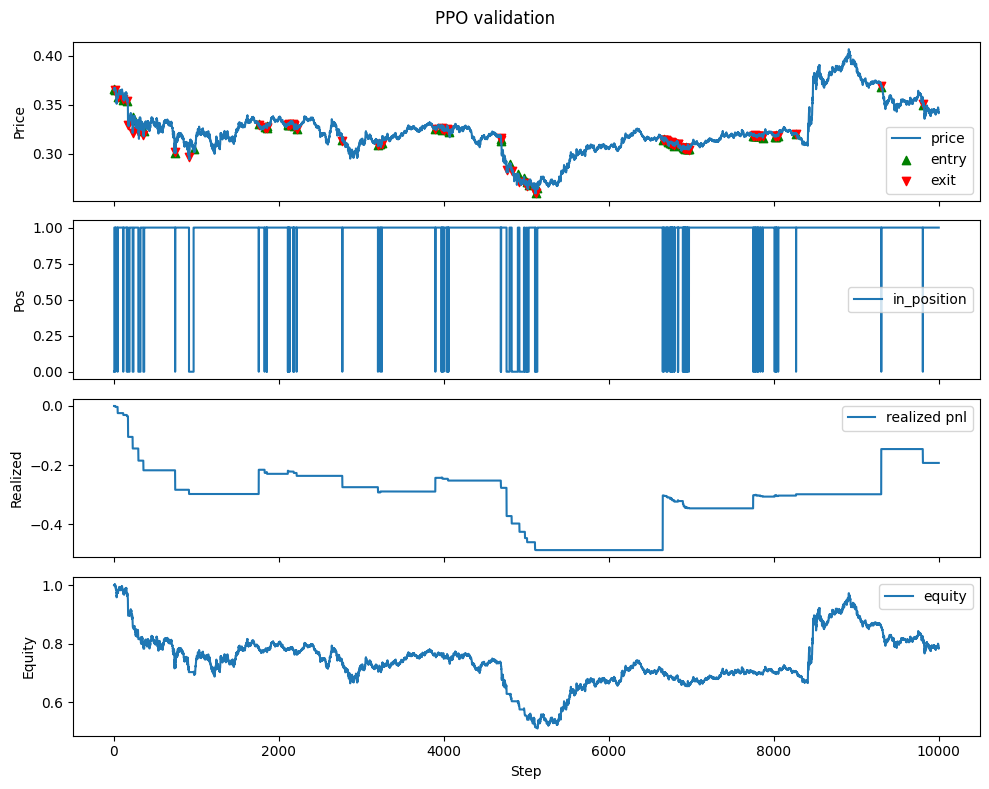


Evaluate_profit:
Realized PnL: -0.1925
Annual Return: -11.2765
Sharpe Ratio: -5.3388
Sortino Ratio: -7.1858
Closed trades: 82
Avg PnL per trade: -0.0022
Maximum Drawdown: 0.4919
Calmar Ratio: -22.9232
Profit Factor: 0.7539
Win Rate: 30.4878
Average Win/Loss Ratio: 1.7189
Recovery Factor: -0.4361
Time Under Water: 0.9994
Value at Risk: 0.0043

collect_trajectories: n_env=20 rollout=512 seq_len=5
Valid Indexes length :578071

Updating PPO:
Epoch 1/10: batch: policy_loss=-0.02258 value_loss=0.09285 entropy=0.31940 approx_kl=0.10705
Epoch 2/10: batch: policy_loss=0.01187 value_loss=0.07733 entropy=0.33087 approx_kl=0.04230
Epoch 3/10: batch: policy_loss=-0.02240 value_loss=0.08690 entropy=0.34849 approx_kl=0.07293
Epoch 4/10: batch: policy_loss=-0.01203 value_loss=0.08979 entropy=0.36781 approx_kl=0.09577
Epoch 5/10: batch: policy_loss=-0.03090 value_loss=0.07663 entropy=0.34134 approx_kl=0.21039
Epoch 6/10: batch: policy_loss=0.07845 value_loss=0.08657 entropy=0.37980 approx_kl=0.25824
E

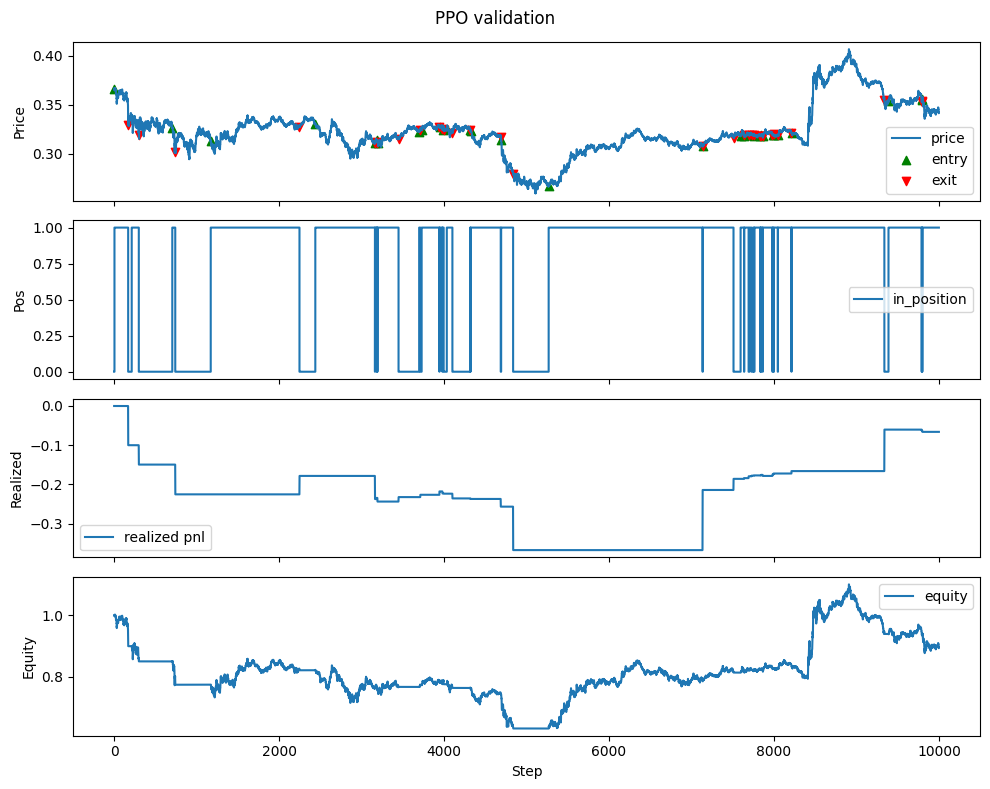


Evaluate_profit:
Realized PnL: -0.0659
Annual Return: -5.4412
Sharpe Ratio: -2.8671
Sortino Ratio: -3.4051
Closed trades: 32
Avg PnL per trade: -0.0019
Maximum Drawdown: 0.3689
Calmar Ratio: -14.749
Profit Factor: 0.8627
Win Rate: 53.125
Average Win/Loss Ratio: 0.7612
Recovery Factor: -0.2806
Time Under Water: 0.9966
Value at Risk: 0.0039


In [ ]:
# @title Обучение на весах SL модели
SL_MODEL_CONFIG = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/config.joblib"
PPO_SAVE_PATH = '/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp2'
CONFIG = joblib.load(SL_MODEL_CONFIG)

SPLITS = (0.82, 0.08, 0.10)
BEST_PATH = CONFIG['best_weights_path']
BEST_CRITIC_PATH = ""
BEST_BACKBONE_PATH = CONFIG['best_backbone_weights_path']
FEATURES = CONFIG['features']
ACCOUNT_F = CONFIG['state']

# @title PPO training parameters
PPO_SEQ_LEN = CONFIG['seq_len'] # ширина окна (такая же как при обучении SL)
PPO_FEATURES_DIM = len(FEATURES) + len(ACCOUNT_F)
PPO_NUM_ACTIONS = CONFIG['num_actions'] # кол-во возможных действий (такое же как при обучении SL)
PPO_UNITS_PER_LAYER = CONFIG['units_per_layer'] #  кол-во нейронов (такое же как при обучении SL)
PPO_DROPOUT = CONFIG['dropout']

# PPO params
PPO_UPDATES = 10       # число обновлений политики за цикл обучения (эпохи)
PPO_N_ENV = 20          # количество параллельных окружений для сбора данных
PPO_ROLLOUT = 512       # длина траектории (количество шагов), собираемой перед обновлением
PPO_ACTOR_LR = 3e-3     # скорость обучения актёра
PPO_CRITIC_LR = 1e-3    # скорость обучения критика
PPO_CLIP_RATIO = 1.2    # центральный гиперпараметр в алгоритме Proximal Policy Optimization. Его называют «шириной зажима»
PPO_C1 = 0.5            # коэффициент перед функцией значения в функции потерь
PPO_C2 = 0.02           # коэффициент перед энтропией в функции потерь
PPO_GAMMA = 0.99        # (discount factor) — коэффициент дисконтирования будущих вознаграждений.
PPO_LAM = 0.95          # параметр обобщённой оценки преимущества (GAE), регулирующий баланс между bias и variance.
PPO_EPOCHS = 10         # количество проходов по батчу при обучении
PPO_BATCH_SIZE = 128    # размер мини-батча для SGD
PPO_TEACHER_KL = 0.1    # начальный вес KL‑регуляризации с teacher‑моделью
PPO_KL_DECAY = 0.8      # коэффициент экспоненциального затухания веса KL
PPO_TARGET_KL = 0.02    # целевое значение KL‑дивергенции для ранней остановки
PPO_MAX_GRAD_NORM = 1.0 # ограничение нормы градиента для стабилизации обучения
PPO_VAL_INTERVAL = 2    # периодичность валидации (через сколько циклов обучения)
PPO_DEBUG = True        # режим вывода отладочной информации

# INDEXES = [("2024-05-01", 1000), ("2024-07-01", 500)]

# Подготавливаем данные и вычисляем статистики нормализации
ppo_train_df, ppo_val_df, ppo_test_df, _feat_stats = prepare_datasets(df,
                                                                      FEATURES,
                                                                      splits=SPLITS,
                                                                      norm_kind='minmax')

TRAIN_CFG = EnvConfig(
    mode=1,
    fee=0.0002,
    spread=0.0001,
    leverage=1.0,
    max_steps=PPO_ROLLOUT+PPO_SEQ_LEN,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

VAL_CFG = EnvConfig(
    mode=1,
    fee=0.0002,
    spread=0.0001,
    leverage=1.0,
    max_steps=10000, #размер валидацилнной выборки
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

actor, critic, train_log, val_log = train(
    ppo_train_df,
    ppo_val_df,
    TRAIN_CFG,
    VAL_CFG,
    PPO_FEATURES_DIM,
    FEATURES,
    seq_len = PPO_SEQ_LEN,
    teacher_weights = BEST_PATH,
    critic_weights = BEST_CRITIC_PATH,
    backbone_weights = BEST_BACKBONE_PATH,
    save_path = PPO_SAVE_PATH,
    num_actions = PPO_NUM_ACTIONS,
    units_per_layer = PPO_UNITS_PER_LAYER,
    dropout = PPO_DROPOUT,
    updates = PPO_UPDATES,
    n_env = PPO_N_ENV,
    rollout = PPO_ROLLOUT,
    actor_lr = PPO_ACTOR_LR,
    critic_lr = PPO_CRITIC_LR,
    clip_ratio = PPO_CLIP_RATIO,
    c1 = PPO_C1,
    c2 = PPO_C2,
    gamma = PPO_GAMMA,
    lam = PPO_LAM,
    epochs = PPO_EPOCHS,
    batch_size = PPO_BATCH_SIZE,
    teacher_kl = PPO_TEACHER_KL,
    kl_decay = PPO_KL_DECAY,
    max_grad_norm = PPO_MAX_GRAD_NORM,
    target_kl = PPO_TARGET_KL,
    val_interval = PPO_VAL_INTERVAL,
    # index_ranges = INDEXES,
    debug = PPO_DEBUG
)

Critic backbone training off
Actor backbone training off
train: debug mode enabled
CPU available: 44
Teacher policy
evaluate_profit metrics={'Realized PnL': -0.0509, 'Annual Return': -20.3819, 'Sharpe Ratio': -14.6953, 'Sortino Ratio': -13.8498, 'Closed trades': 9, 'Avg PnL per trade': -0.0055, 'Maximum Drawdown': 2.3694, 'Calmar Ratio': -8.602, 'Profit Factor': 0.3966, 'Win Rate': 44.4444, 'Average Win/Loss Ratio': 0.4958, 'Recovery Factor': -0.0491, 'Time Under Water': 0.6633, 'Value at Risk': 0.0031}


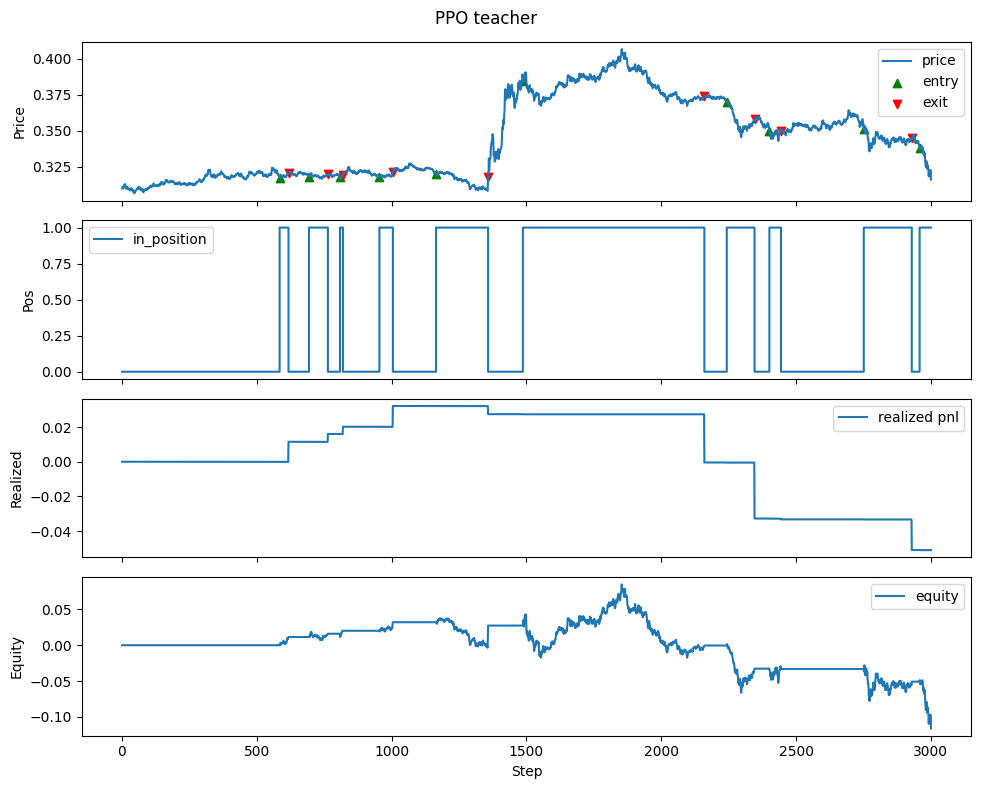

collect_trajectories: n_env=10 rollout=256 seq_len=5
Indexes length :585383
ppo_update: epoch 1/10
batch: policy_loss=0.03191 value_loss=0.51990 entropy=0.44787 approx_kl=0.03294
ppo_update: epoch 2/10
batch: policy_loss=0.00130 value_loss=0.51096 entropy=0.42124 approx_kl=0.01661
ppo_update: epoch 3/10
batch: policy_loss=-0.02976 value_loss=0.38380 entropy=0.42550 approx_kl=0.01430
ppo_update: epoch 4/10
batch: policy_loss=-0.04251 value_loss=0.24170 entropy=0.40677 approx_kl=0.03676
ppo_update: epoch 5/10
batch: policy_loss=0.00066 value_loss=0.33776 entropy=0.42348 approx_kl=0.02881
ppo_update: epoch 6/10
batch: policy_loss=-0.01286 value_loss=0.31498 entropy=0.45747 approx_kl=0.03935
ppo_update: epoch 7/10
batch: policy_loss=-0.02369 value_loss=0.30208 entropy=0.37210 approx_kl=-0.00173
batch: policy_loss=-0.00672 value_loss=0.27172 entropy=0.42671 approx_kl=-0.00263
batch: policy_loss=0.02260 value_loss=0.23842 entropy=0.42243 approx_kl=0.03576
ppo_update: epoch 8/10
batch: policy

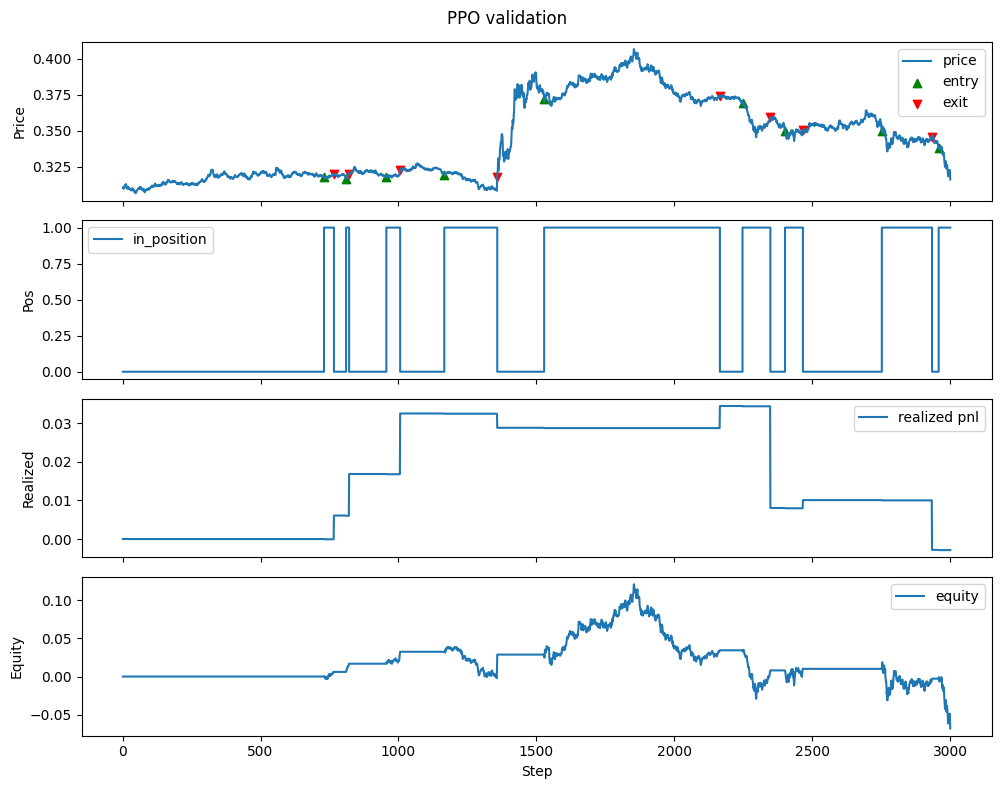

update=0 avg_reward=0.046 profit=-0.003 kl_coef=0.0250
collect_trajectories: n_env=10 rollout=256 seq_len=5
Indexes length :585383
ppo_update: epoch 1/10
batch: policy_loss=-0.03923 value_loss=0.33283 entropy=0.43870 approx_kl=0.02391
ppo_update: epoch 2/10
batch: policy_loss=0.02188 value_loss=0.44418 entropy=0.51928 approx_kl=0.06385
ppo_update: epoch 3/10
batch: policy_loss=-0.02394 value_loss=0.42121 entropy=0.45475 approx_kl=0.02230
ppo_update: epoch 4/10
batch: policy_loss=-0.01237 value_loss=0.46463 entropy=0.46529 approx_kl=0.04141
ppo_update: epoch 5/10
batch: policy_loss=-0.00355 value_loss=0.36839 entropy=0.45048 approx_kl=0.03703
ppo_update: epoch 6/10
batch: policy_loss=0.02148 value_loss=0.34392 entropy=0.48589 approx_kl=0.05818
ppo_update: epoch 7/10
batch: policy_loss=0.10011 value_loss=0.39166 entropy=0.49301 approx_kl=-0.00326
batch: policy_loss=0.01242 value_loss=0.32102 entropy=0.47456 approx_kl=0.03704
ppo_update: epoch 8/10
batch: policy_loss=-0.04548 value_loss=0

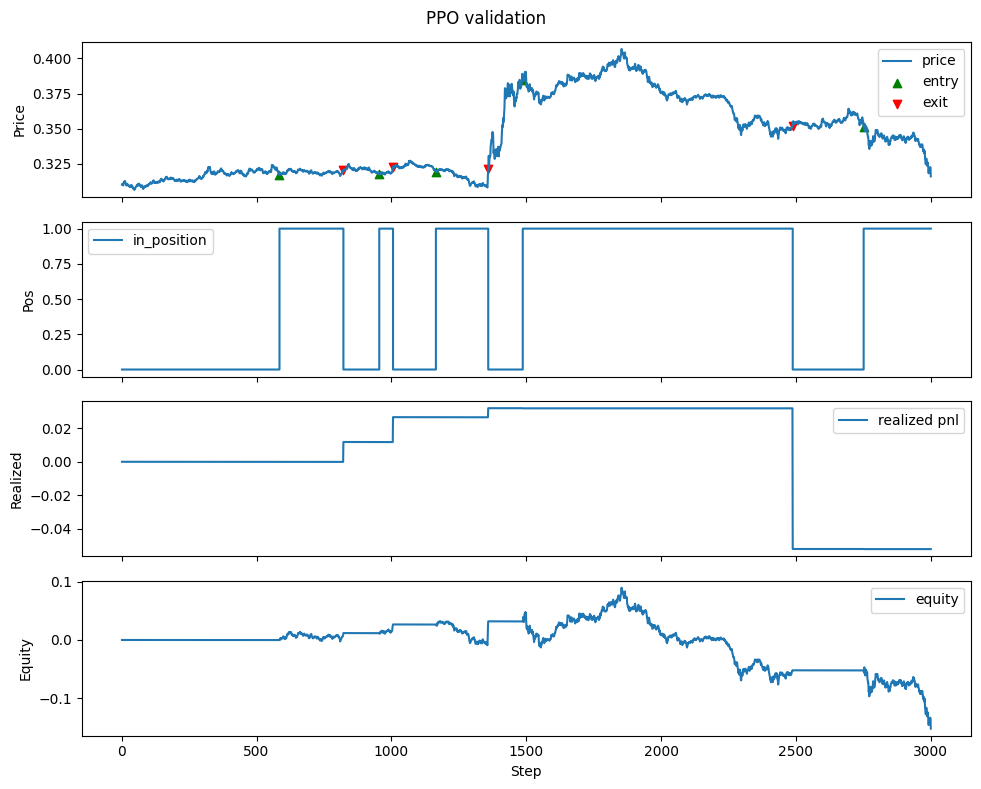

update=1 avg_reward=0.502 profit=-0.052 kl_coef=0.0125


In [ ]:
# @title Fine tuning

# Параметры
SL_MODEL_CONFIG = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/config.joblib"
PPO_SAVE_PATH = '/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/ft'
CONFIG = joblib.load(SL_MODEL_CONFIG)

SPLITS = (0.83, 0.12, 0.05)
BEST_PATH_ACTOR = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp2/actor_best_1.weights.h5"
BEST_CRITIC_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp2/critic_best_1.weights.h5"
BEST_BACKBONE_PATH = ""
FEATURES = CONFIG['features']
ACCOUNT_F = CONFIG['state']

# @title PPO training parameters
PPO_SEQ_LEN = CONFIG['seq_len'] # ширина окна (такая же как при обучении SL)
PPO_FEATURES_DIM = len(FEATURES) + len(ACCOUNT_F)
PPO_NUM_ACTIONS = CONFIG['num_actions'] # кол-во возможных действий (такое же как при обучении SL)
PPO_UNITS_PER_LAYER = CONFIG['units_per_layer'] #  кол-во нейронов (такое же как при обучении SL)
PPO_DROPOUT = CONFIG['dropout']

# INDEXES = [("2024-05-01", 1000), ("2024-07-01", 500)]

# PPO training parameters
PPO_UPDATES = 2
PPO_N_ENV = 10
PPO_ROLLOUT = 256
PPO_ACTOR_LR = 3e-3
PPO_CRITIC_LR = 1e-3
PPO_CLIP_RATIO = 1.5
PPO_C1 = 0.5
PPO_C2 = 0.02
PPO_EPOCHS = 10
PPO_BATCH_SIZE = 64
PPO_TEACHER_KL = 0.05
PPO_KL_DECAY = 0.5
PPO_TARGET_KL = 0.001
PPO_MAX_GRAD_NORM = 0.5
PPO_VAL_INTERVAL = 1
PPO_DEBUG = True
PPO_FUNE_TUNE = True

TRAIN_CFG = EnvConfig(
    mode=1,
    fee=0.0002,
    spread=0.0001,
    leverage=1.0,
    max_steps=PPO_ROLLOUT+PPO_SEQ_LEN,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

VAL_CFG = EnvConfig(
    mode=1,
    fee=0.0002,
    spread=0.0001,
    leverage=1.0,
    max_steps=5000,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

actor, critic, train_log, val_log = train(
    ppo_train_df,
    ppo_val_df,
    TRAIN_CFG,
    VAL_CFG,
    PPO_FEATURES_DIM,
    FEATURES,
    seq_len = PPO_SEQ_LEN,
    teacher_weights = BEST_PATH_ACTOR,
    critic_weights = BEST_CRITIC_PATH,
    backbone_weights = BEST_BACKBONE_PATH,
    save_path = PPO_SAVE_PATH,
    num_actions = PPO_NUM_ACTIONS,
    units_per_layer = PPO_UNITS_PER_LAYER,
    dropout = PPO_DROPOUT,
    updates = PPO_UPDATES,
    n_env = PPO_N_ENV,
    rollout = PPO_ROLLOUT,
    actor_lr = PPO_ACTOR_LR,
    critic_lr = PPO_CRITIC_LR,
    clip_ratio = PPO_CLIP_RATIO,
    c1 = PPO_C1,
    c2 = PPO_C2,
    epochs = PPO_EPOCHS,
    batch_size = PPO_BATCH_SIZE,
    teacher_kl = PPO_TEACHER_KL,
    kl_decay = PPO_KL_DECAY,
    max_grad_norm = PPO_MAX_GRAD_NORM,
    target_kl = PPO_TARGET_KL,
    val_interval = PPO_VAL_INTERVAL,
    # index_ranges = INDEXES,
    debug = PPO_DEBUG,
    fine_tune = PPO_FUNE_TUNE
)

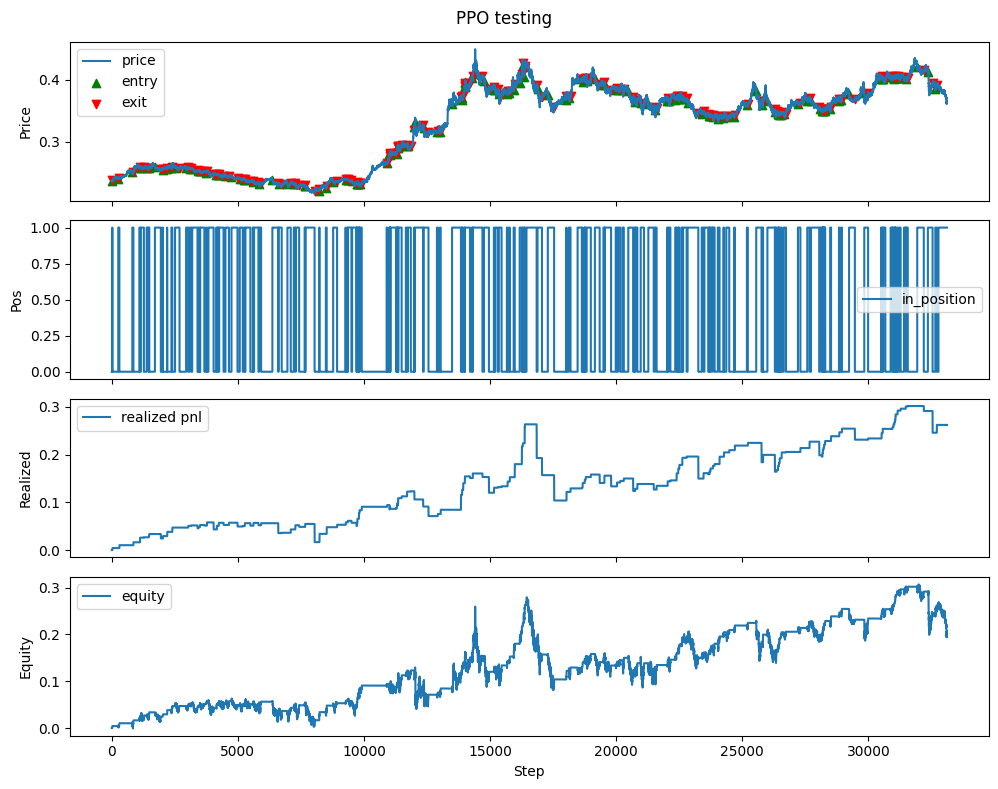

Metrics Report
Realized PnL: 0.2623
Annual Return: 3.2753
Sharpe Ratio: 2.881
Sortino Ratio: 2.5102
Closed trades: 172
Avg PnL per trade: 0.0017
Maximum Drawdown: 1.0796
Calmar Ratio: 3.0339
Profit Factor: 1.4037
Win Rate: 77.3256
Average Win/Loss Ratio: 0.4116
Recovery Factor: 0.1912
Time Under Water: 0.8964
Value at Risk: 0.0024


In [ ]:
# @title Test simulation
ACTOR_WEIGHTS = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/best_lstm.weights.h5"
SL_MODEL_CONFIG = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/config.joblib"
CONFIG = joblib.load(SL_MODEL_CONFIG)

START = "2024-01-20"
END = "2025-05-23"
TEST_FROM = "2025-05-01"

# Загружаем параметры из сохраненного конфига
PPO_SEQ_LEN = CONFIG['seq_len']
PPO_FEATURES_DIM = len(CONFIG['features']) + len(CONFIG['state'])
PPO_UNITS_PER_LAYER = CONFIG['units_per_layer']
PPO_DROPOUT = CONFIG['dropout']
PPO_NUM_ACTIONS = CONFIG['num_actions']
FEATURES = CONFIG['features']

dataframe = df.loc[START:END].copy()

_,_,ppo_test_df, _ = prepare_datasets(dataframe,
                                  FEATURES,
                                  test_from=TEST_FROM,
                                  norm_kind='minmax')

TEST_CFG = EnvConfig(
    mode=1,
    fee=0.0002,
    spread=0.0001,
    leverage=1.0,
    max_steps=1e9,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

testing_simulation(
    ppo_test_df,
    ACTOR_WEIGHTS,
    PPO_SEQ_LEN,
    PPO_FEATURES_DIM,
    PPO_UNITS_PER_LAYER,
    PPO_DROPOUT,
    PPO_NUM_ACTIONS,
    FEATURES,
    TEST_CFG,
    debug=False
)